# Εργασία 1. Επιβλεπόμενη Μάθηση - Kaggle dataset
Neural Networks - Team 22\
\
Alexandros Tsafos el18211\
Christina Kostaki el18136\
Sofia Vouzika el18843
  

Αρχικά κάνουμε upgrade στις βιβλοθήκες που θα χρειαστούμε, αν δεν έχουμε ήδη κάνει. Στο Colab θα χρεαστεί πιθανότατα να κάνουμε restart το runtime.

In [42]:
!pip install --upgrade pip
!pip install scikit-learn --upgrade 
!pip install numpy --upgrade 
!pip install --upgrade matplotlib 
!pip install --upgrade pandas
!pip install tabulate
!pip install -U imbalanced-learn
!pip install optuna
!pip install plotly

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

![Κaggle Logo](https://upload.wikimedia.org/wikipedia/commons/7/7c/Kaggle_logo.png "Kaggle")

To [Kaggle](https://www.kaggle.com) είναι το δεύτερο αποθετήριο datasets για Machine Learning που θα δούμε σε αυτή την άσκηση. Το dataset με το οποίο θα δουλέψουμε είναι το [Codon Usage](https://www.kaggle.com/datasets/meetnagadia/condon-usage-dataset). Το dataset περιλαμβάνει διάφορες πληροφορίες σχετικά με την χρήση κωδικονίων σε ένα μεγάλο εύρος οργανισμών, με σκοπό να γίνει ταξινόμηση κατά γένος ("Βασίλειο").





In [43]:
import pandas as pd
import numpy as np

def conv(val):
    try:
        return float(val)
    except:
        return np.nan

# Read CSV and replace the uknown Age values with the average Age.
dataset = pd.read_csv("codon_usage.csv", low_memory=False, converters={'UUU': conv, 'UUC':conv})
print(dataset.shape)

print(dataset.isnull().sum().sort_values(ascending=False))



(13028, 69)
UUU        2
UUC        1
Kingdom    0
UAU        0
UGU        0
          ..
GGU        0
GGC        0
GGA        0
GGG        0
UGA        0
Length: 69, dtype: int64


In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   SpeciesID    13028 non-null  int64  
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13026 non-null  float64
 6   UUC          13027 non-null  float64
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  GUC          13028 non-null  float64
 19  GUA 

### Απαραίτητο Preprocessing

Σε αυτό το σημείο πρέπει να γίνει το ελάχιστο preprocessing, έτσι ώστε το sci-kit learn να μπορέσει να επεξεργαστεί τα δεδομένα.

Παρακάτω θα δούμε πιο αναλυτικά αυτές τις αλλαγές

Η στήλη Species name δεν μπορεί να χρησιμοποιηθεί, καθώς είναι τύπου string. Μπορούμε να την αφαιρέσουμε, αφού το SpeciesID μας είναι αρκετό για τον καθορισμό του είδους. Ο owner των δεδομένων έχει κάνει ήδη προεργασία για εμάς, έχοντας μεριμνήσει για αυτή την εξάρτηση. Σε αντίθετη περίπτωση, θα έπρεπε να κάνουμε εμείς το class mapping.

In [45]:
# Cannot process string values in MLP. 
# We have the ID as index se we can drop the whole column
dataset = dataset.drop(columns='SpeciesName')

 To dataset έχει 3 ΝaN τιμές. Αυτές πρέπει να αλλάξουν για να μπορέσουμε να συνεχίσουμε.
 Επιλέγουμε να τις κάνουμε drop, καθώς αποτελούν αμελητέο μέρος των δεδομένων.

In [46]:
# Drop the Null Values. These are 2 out of 13028 rows
dataset.dropna(inplace=True)
dataset.set_index("SpeciesID")

print("The NaN values now are: " + str(dataset.isnull().sum().sum()))
print(dataset.shape)

The NaN values now are: 0
(13026, 68)


Έχουμε ένα dataframe, από το οποίο πρέπει να εξάγουμε δεδομένα συμβατά με το sklearn

In [47]:
# Extract the values
label_names, counts = np.unique(dataset["Kingdom"], return_counts=True) 
labels = dataset["Kingdom"].values
features = dataset.iloc[:,1:].values
feature_names = dataset.columns[1:]

In [48]:
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(str(u)+':'+str(c))

arc:126
bct:2919
inv:1345
mam:572
phg:220
plm:18
pln:2523
pri:180
rod:215
vrl:2831
vrt:2077


To dataset δεν είναι ισορροπημένο. Το plm εμφανίζεται 18 φορές, ενώ το bct 2919.
Περισσότερες από 100 φορές παραπάνω.

In [49]:
# οι διαστάσεις όλων των χαρακτηριστικών
print(features.shape)


(13026, 67)


### Train and Test split

Θα κάνουμε ένα απλό train and test split 70% εκπαίδευση και 30% δείγματα.
Το διαλέγουμε σαν απλή και συνηθισμένη τιμή για την επίδοση out-of-the-box. Αργότερα, κατά την βελτιστοποίηση, θα αποφασίσουμε αν αυτό το ποσοστό θα αλλάξει.

In [50]:
from sklearn.model_selection import train_test_split

# Split our data
train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.3)

In [51]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

kaggle_accuracy = {}
kaggle_f1 = {}
kaggle_fit = {}
kaggle_pred = {}

def dummy_metrics(solver, const = None):

    name = 'dummy_' + solver
    model = DummyClassifier(strategy=solver, constant=const)
    start = time.time()
    model.fit(train, train_labels)
    fit_time  = time.time() - start
    start = time.time()
    preds = model.predict(test)
    pred_time  = time.time() - start

    kaggle_pred[name] = pred_time
    kaggle_fit[name] = fit_time
    kaggle_accuracy[name] = accuracy_score(test_labels, preds)
    kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

dummy_metrics('uniform')
dummy_metrics('most_frequent')
dummy_metrics('stratified')
dummy_metrics('constant', 'arc')
dummy_metrics('constant', 'mam')

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

def mlp_metrics(solver):

    name = 'mlp_' + solver
    model = MLPClassifier(solver=solver)
    start = time.time()
    model.fit(train, train_labels)
    fit_time  = time.time() - start
    start = time.time()
    preds = model.predict(test)
    pred_time  = time.time() - start

    kaggle_pred[name] = pred_time
    kaggle_fit[name] = fit_time
    kaggle_accuracy[name] = accuracy_score(test_labels, preds)
    kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

mlp_metrics('adam')
mlp_metrics('lbfgs')
mlp_metrics('sgd')



## Σχόλιο

Ο SVM, αργεί πάρα πολύ να κάνει fit, αν δεν μπει όριο στο max_iter. Αυτό είναι λογικό, αφού κρατά έναν ΝxN πίνακα για τις αποστάσεις όλων των σημείων. Με 13000 εγγραφές, καταλαβαίνουμε πως αυτός ο πίνακας είναι πολύ μεγάλος για να γίνει γρήγορα η επεξεργασία του. Για τώρα, θα περιορίσουμε τις επαναλήψεις του, ενώ, κατά την βελτιστοποίηση, θα μικρύνουμε αρκετά το dataset μας.

In [53]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

def svc_metrics(solver):

    name = 'svc_' + solver
    model = SVC(kernel=solver, random_state=0, C=1, max_iter=100000)
    start = time.time()
    model.fit(train, train_labels)
    fit_time  = time.time() - start
    start = time.time()
    preds = model.predict(test)
    pred_time  = time.time() - start

    kaggle_pred[name] = pred_time
    kaggle_fit[name] = fit_time
    kaggle_accuracy[name] = accuracy_score(test_labels, preds)
    kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

svc_metrics('poly')
svc_metrics('rbf')

In [54]:
from IPython.display import Markdown

merged_metrics = [(k, kaggle_fit[k], kaggle_pred[k], kaggle_accuracy[k], kaggle_f1[k]) for k in sorted(kaggle_accuracy, key=kaggle_accuracy.get, reverse=True)]

df = pd.DataFrame(merged_metrics, columns=['Classifier', 'Fit Time(s)', 'Test Time(s)','Accuracy','F1-macro'])
Markdown(df.to_markdown())

|    | Classifier          |   Fit Time(s) |   Test Time(s) |   Accuracy |   F1-macro |
|---:|:--------------------|--------------:|---------------:|-----------:|-----------:|
|  0 | svc_rbf             |    4.46929    |    3.18985     |  0.298106  | 0.0968492  |
|  1 | mlp_adam            |    5.43396    |    0.00485611  |  0.276868  | 0.100331   |
|  2 | svc_poly            |   10.5125     |    1.26711     |  0.237206  | 0.0598049  |
|  3 | dummy_most_frequent |    0.00194502 |    0.000301838 |  0.223644  | 0.0332307  |
|  4 | mlp_sgd             |    1.19249    |    0.00204086  |  0.190123  | 0.0290456  |
|  5 | mlp_lbfgs           |    1.95445    |    0.00511813  |  0.185517  | 0.0462601  |
|  6 | dummy_stratified    |    0.00213099 |    0.00103712  |  0.163767  | 0.0861298  |
|  7 | dummy_uniform       |    0.00280118 |    0.00117397  |  0.093654  | 0.0728173  |
|  8 | dummy_constant      |    0.00193286 |    5.00679e-05 |  0.0437564 | 0.00762219 |

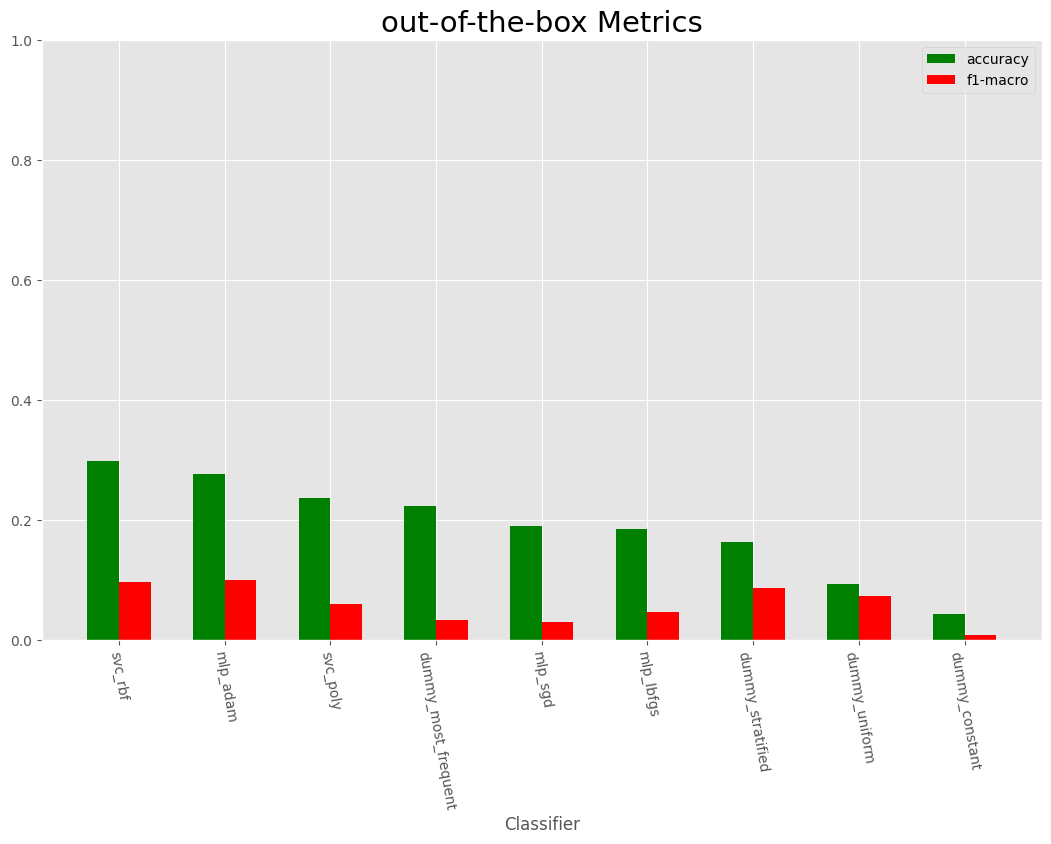

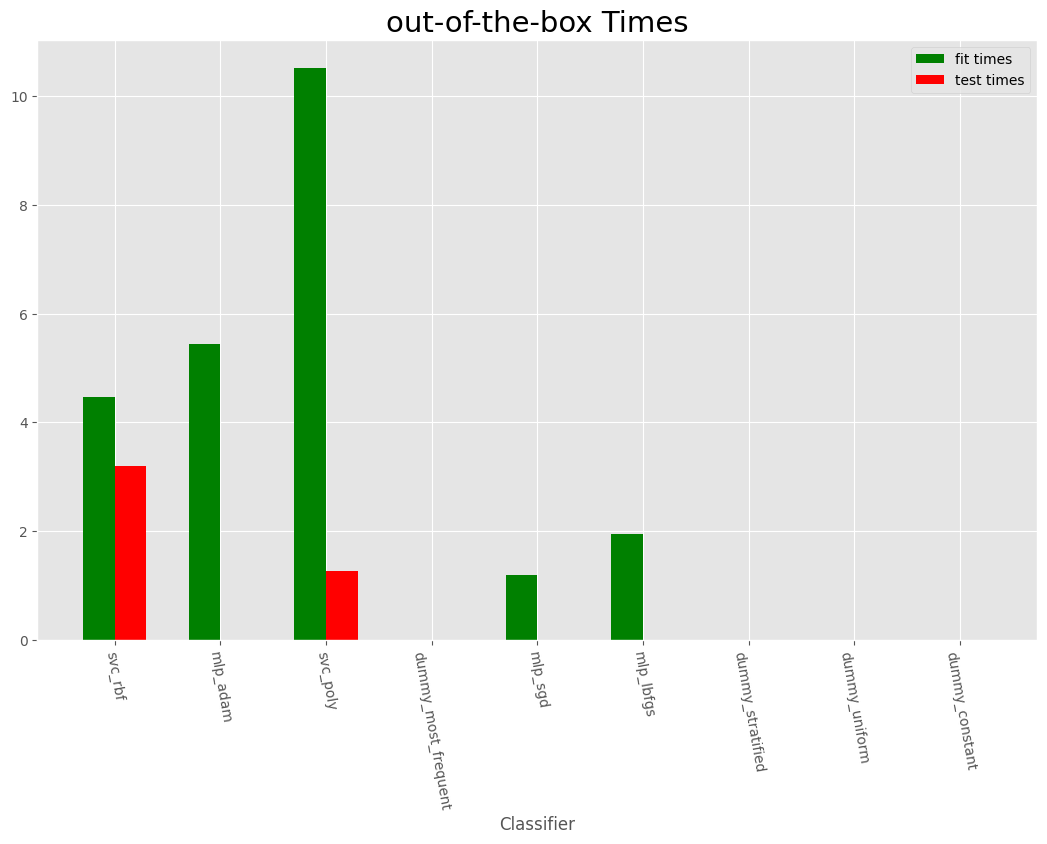

In [55]:
import matplotlib.pyplot as plt

keys, fit_times, test_times, accuracy, f1_macro = zip(*merged_metrics)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, accuracy, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, f1_macro, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['accuracy', 'f1-macro'])
ax.set_title('out-of-the-box Metrics',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)

plt.ylim(0, 1)

plt.show()



fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, fit_times, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, test_times, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['fit times', 'test times'])
ax.set_title('out-of-the-box Times',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)


plt.show()

### Σχολιασμός

Σε αντίθεση με το UCI dataset, το οποίο ήταν εξαιρετικά μικρότερο, εδώ βλέπουμε κακές επιδόσεις out-of-the-box. Είναι προφανές, πως η βελτριστοποίηση είναι απαραίτητη για να επιτευχθεί ένα αξιοπρεπές αποτέλεσμα.  

## Βελτιστοποίηση με παρατηρήσεις

Επιλέγουμε να βλετιστοποιήσουμε τον MLP adam και SVC rbf

Έχει γίνει ήδη ένα μικρό μέρος προεπεξεργασίας των δεδομένων, το ελάχιστο για να μπορέσουμε να μετρήσουμε μία out-of-the-box μέτρηση αποδοτικότητας.

Θα χρησιμοποιήσουμε έτοιμες συναρτήσεις από τα sklearn και Optuna

Αρχικά, θα πειραματιστούμε μόνοι μας για την βελτιστοποίηση των μοντέλων,  εξετάζοντας την συμπεριφορά των μοντέλων σε διάφορες αλλαγές.Στην συνέχεια θα πραματοποιηθεί ένα study με την βοήθεια του optuna, για την εύρεση των καλύτερων παραμέτρων

### Scaling

Τα χαρακτηριστικά με πολύ μεγάλες διαφορές στις τιμές τους μπορούν να δημιουργήσουν προβλήματα στην εκπαίδευση. Για το λόγο αυτό θα εφαρμόσουμε τη κανονικοποίηση για να μετασχηματίσουμε τις τιμές των χαρακτηριστικών και να αμβλυθούν οι διαφορές αυτές.

In [56]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

### Over/Under Sampling

Tα τόσο χαμηλά αποτελέσματα είναι αναμενόμενα, καθώς τo dataset δεν είναι ισορροπημένο. Το μέγεθός του μας επιτρέπει να εφαρμόσουμε oversampling.

In [57]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MultiLabelBinarizer

ros = RandomOverSampler()
train_resampled, train_labels_resampled = ros.fit_resample(train_scaled, train_labels)

train_resampled.shape


(22495, 67)

In [58]:
unique, counts = np.unique(train_labels_resampled, return_counts=True)

for u, c in zip(unique, counts):
    print(str(u)+':'+str(c))

arc:2045
bct:2045
inv:2045
mam:2045
phg:2045
plm:2045
pln:2045
pri:2045
rod:2045
vrl:2045
vrt:2045


### Μείωση Διαστατικότητας (PCA)

Θα εμφανίσουμε το διάγραμμα # Παραμέτρων - Συνολικής διακύμανσης, με σκοπό την επιλογή του αριθμού των παραμέτρων που θα παραμείνουν στα δεδομένα.

In [59]:
from sklearn.decomposition import PCA 

pca = PCA()

train_PCA = pca.fit_transform(train_resampled)
test_PCA = pca.transform(test_scaled)

print(train_PCA.shape)

(22495, 67)


[0.29196094 0.49919015 0.55389028 0.58968418 0.6247812  0.65196196
 0.67798241 0.69668662 0.71417101 0.72984377 0.74517671 0.75999713
 0.77284515 0.78448839 0.79562588 0.80615961 0.8161086  0.82531747
 0.83429955 0.84243041 0.84997529 0.85720982 0.86424084 0.87092459
 0.87718824 0.88316593 0.88877432 0.89428723 0.89963728 0.90483789
 0.9096484  0.9143467  0.91882753 0.92320342 0.92732251 0.93128467
 0.93510626 0.93868355 0.94221225 0.9455754  0.94884213 0.95198686
 0.95502553 0.95793503 0.96077507 0.96355008 0.9662446  0.96876851
 0.97124872 0.97361657 0.97592328 0.97819573 0.98039323 0.98241839
 0.98438438 0.98627741 0.98802378 0.98967909 0.99119804 0.99267777
 0.99411122 0.99549814 0.99680888 0.99802364 0.99905298 1.
 1.        ]


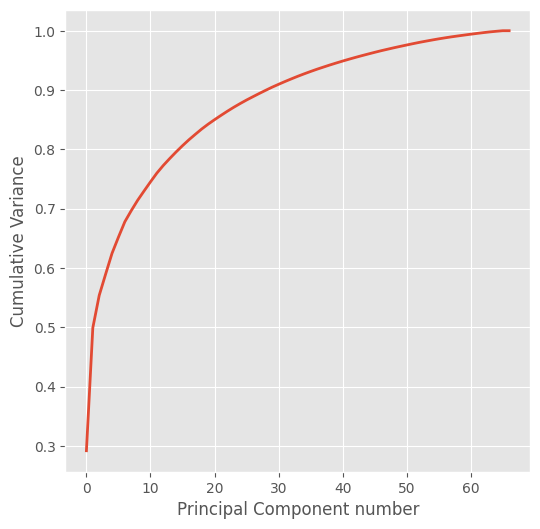

In [60]:
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(6, 6))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

In [61]:
pca = PCA(n_components=55)

train_PCA = pca.fit_transform(train_resampled)
test_PCA = pca.transform(test_scaled)

print(train_PCA.shape)

(22495, 55)


### Αποτελέσματα Εξισορρόπησης και Κανονικοποίησης

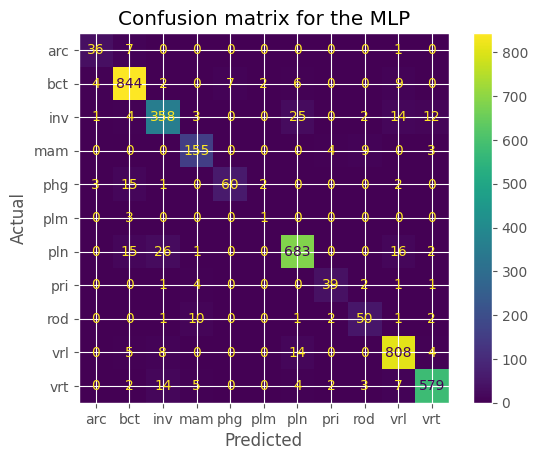

In [62]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

name = 'mlp_opt_adam'
mlp = MLPClassifier()
start = time.time()
mlp.fit(train_resampled, train_labels_resampled)
fit_time  = time.time() - start
start = time.time()
preds = mlp.predict(test_scaled)
pred_time  = time.time() - start

kaggle_pred[name] = pred_time
kaggle_fit[name] = fit_time
kaggle_accuracy[name] = accuracy_score(test_labels, preds)
kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

plot_confusion_matrix(mlp, test_scaled, test_labels)  
plt.title('Confusion matrix for the MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 


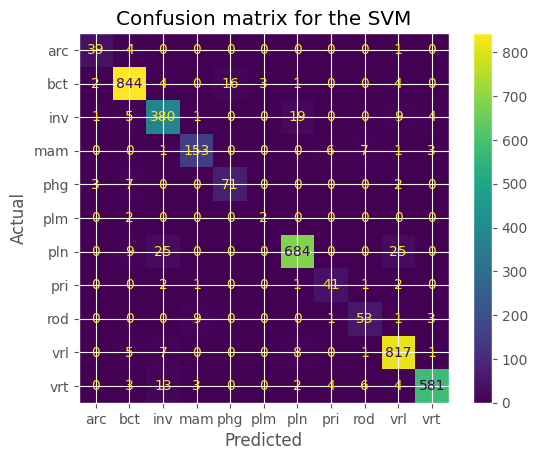

In [63]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

name = 'svm_opt_rbf'
svm = SVC()
start = time.time()
svm.fit(train_resampled, train_labels_resampled)
fit_time  = time.time() - start
start = time.time()
preds = svm.predict(test_scaled)
pred_time  = time.time() - start

kaggle_pred[name] = pred_time
kaggle_fit[name] = fit_time
kaggle_accuracy[name] = accuracy_score(test_labels, preds)
kaggle_f1[name] = f1_score(test_labels, preds, average='macro')

plot_confusion_matrix(svm, test_scaled, test_labels)  
plt.title('Confusion matrix for the SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 


## Παρατηρήσεις κατά τον πειραματισμό

Κατά τις δοκιμές διαφόρων τρόπων βελτιστοποίησης, διαπιστώθηκαν τα εξής:


Scaling - Variance Threshold
- Η χρήση Scaler παρουσίασε εξαιρετική βελτίωση
- H απόκλιση των τιμών στις παραμέτρους ήταν πολύ μικρή για να μπορέσουμε να αφαιρέσουμε χαραλτηριστικά. Η διαστατικότητα θα μειωθεί αλλιώς

Over/Under Sampling
- Με χρήση undersampling, το dataset πέφτει στις 140 σειρές. Ο χρόνος γίνεται ελάχιστος, όμως η αποδοση πέφτει. Λογικό, αφού έχουμε πλεόν 18 δείγματα για κάθε κλάση.
- Βέλτιστη επιλογή φαίνεται να είναι το oversampling.

PCA
- Από το διάγραμμα παρατηρήσαμε πως μια καλή τιμή για την αναλογία χαρακτηριστικών-περιγραφικότητας είναι τα 45.

## Βελτιστοποίηση με Optuna

Η βιβλιοθήκη Optuna προσφέρει την δυνατότητα για εύρεση υπερπαραμέτρων των μοντέλων, μελετώντας την επίδοσή τους με διάφορες τιμές. Θα την χρησιμοποήσουμε σε συνδυασμό με GridSearch, για να βελτιστοποιήσουμε τα μοντέλα μας ως προς τις δύο μετρικές. Ταυτόχρονα, θα γίνει χρήση Pipeline.

Για τον MLP, το Optuna θα επιλέξει τον αριθμό των κρυγών επιπέδων, καθώς και τον αριθμό μονάδων του κάθε επιπέδου.

Για τον SVC, το Optuna θα επιλέξει την παράμετρο Κανονικοποίησης C.

### Τελικά Αποτελέσματα

In [64]:
import optuna
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


def objective_func(trial):

    n_layers = trial.suggest_int('n_layers', 1, 4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))

    mlp = MLPClassifier(hidden_layer_sizes=tuple(layers), max_iter=300)
    pipe = Pipeline(steps=[('scaler', scaler), ('ros', ros), ('pca', pca), ('mlp', mlp)])
    n_components = list(range(50,60))
    estimator = GridSearchCV(pipe, dict( pca__n_components=n_components), cv=2, scoring='f1_macro', refit='accuracy', n_jobs=-1, verbose=1)
    estimator.fit(train, train_labels)
    preds = estimator.predict(test)

    f1 =f1_score(test_labels, preds, average='macro') 
    acc =accuracy_score(test_labels, preds)

    return f1, acc 

mlp_study = optuna.create_study(directions=['maximize', 'maximize']) 
mlp_study.optimize(objective_func, n_trials=30)

sorted_trials = sorted(mlp_study.best_trials, key=lambda t: t.values[0]*t.values[1], reverse=True)

study_dur = sorted_trials[0].duration
dict_time = ('%d.%d'%(study_dur.seconds, study_dur.microseconds))
kaggle_pred['optuna_mlp'] = dict_time
kaggle_fit['optuna_mlp'] = dict_time
kaggle_accuracy['optuna_mlp'] = sorted_trials[0].values[1]
kaggle_f1['optuna_mlp'] = sorted_trials[0].values[0]

[I 2022-11-26 21:25:12,936] A new study created in memory with name: no-name-317a6b15-b7fb-48f0-9d9e-ba792da19ab8


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:25:53,077] Trial 0 finished with values: [0.8105350930736545, 0.907625383828045] and parameters: {'n_layers': 4, 'n_units_0': 33, 'n_units_1': 82, 'n_units_2': 76, 'n_units_3': 75}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:26:26,141] Trial 1 finished with values: [0.7757947916136476, 0.904042988741044] and parameters: {'n_layers': 2, 'n_units_0': 39, 'n_units_1': 79}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:26:58,063] Trial 2 finished with values: [0.8212568091045621, 0.915813715455476] and parameters: {'n_layers': 2, 'n_units_0': 88, 'n_units_1': 89}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:27:30,115] Trial 3 finished with values: [0.8163878209774761, 0.917093142272262] and parameters: {'n_layers': 2, 'n_units_0': 53, 'n_units_1': 73}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:28:06,085] Trial 4 finished with values: [0.8150813651219374, 0.9173490276356192] and parameters: {'n_layers': 3, 'n_units_0': 73, 'n_units_1': 46, 'n_units_2': 46}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:28:35,477] Trial 5 finished with values: [0.7539195493794311, 0.8994370522006141] and parameters: {'n_layers': 3, 'n_units_0': 30, 'n_units_1': 40, 'n_units_2': 23}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:29:04,845] Trial 6 finished with values: [0.8235473421406062, 0.9204196519959058] and parameters: {'n_layers': 1, 'n_units_0': 62}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:29:45,178] Trial 7 finished with values: [0.7517593302508655, 0.9037871033776868] and parameters: {'n_layers': 1, 'n_units_0': 46}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:30:27,076] Trial 8 finished with values: [0.7416606284975127, 0.8892016376663255] and parameters: {'n_layers': 1, 'n_units_0': 37}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:30:56,770] Trial 9 finished with values: [0.8286124623823636, 0.9234902763561924] and parameters: {'n_layers': 1, 'n_units_0': 91}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:32:06,093] Trial 12 finished with values: [0.7919004749301094, 0.915813715455476] and parameters: {'n_layers': 3, 'n_units_0': 97, 'n_units_1': 15, 'n_units_2': 51}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:33:19,052] Trial 14 finished with values: [0.8013418983192984, 0.9106960081883316] and parameters: {'n_layers': 4, 'n_units_0': 43, 'n_units_1': 90, 'n_units_2': 30, 'n_units_3': 35}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:33:52,987] Trial 15 finished with values: [0.7764925817190774, 0.898157625383828] and parameters: {'n_layers': 4, 'n_units_0': 55, 'n_units_1': 10, 'n_units_2': 75, 'n_units_3': 11}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:34:23,381] Trial 16 finished with values: [0.8055647936168085, 0.9176049129989765] and parameters: {'n_layers': 2, 'n_units_0': 64, 'n_units_1': 94}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:34:50,911] Trial 17 finished with values: [0.7940746444843252, 0.9129989764585466] and parameters: {'n_layers': 2, 'n_units_0': 72, 'n_units_1': 29}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:36:07,506] Trial 19 finished with values: [0.809476365480119, 0.9224667349027635] and parameters: {'n_layers': 4, 'n_units_0': 92, 'n_units_1': 70, 'n_units_2': 89, 'n_units_3': 94}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2022-11-26 21:36:47,276] Trial 20 finished with values: [0.7563321154393526, 0.8915046059365405] and parameters: {'n_layers': 1, 'n_units_0': 30}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:37:22,021] Trial 21 finished with values: [0.7801316355302969, 0.906345957011259] and parameters: {'n_layers': 2, 'n_units_0': 34, 'n_units_1': 68}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:37:54,389] Trial 22 finished with values: [0.8139423809466163, 0.9155578300921188] and parameters: {'n_layers': 1, 'n_units_0': 92}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:38:24,774] Trial 23 finished with values: [0.8140078308373174, 0.9183725690890481] and parameters: {'n_layers': 2, 'n_units_0': 80, 'n_units_1': 83}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:38:55,695] Trial 24 finished with values: [0.8199404614514453, 0.9181166837256909] and parameters: {'n_layers': 2, 'n_units_0': 69, 'n_units_1': 47}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:39:25,776] Trial 25 finished with values: [0.7550156167223577, 0.8889457523029682] and parameters: {'n_layers': 2, 'n_units_0': 20, 'n_units_1': 50}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:39:51,114] Trial 26 finished with values: [0.8118147901411866, 0.922978505629478] and parameters: {'n_layers': 2, 'n_units_0': 77, 'n_units_1': 26}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:40:16,803] Trial 27 finished with values: [0.7999041035694237, 0.9122313203684749] and parameters: {'n_layers': 4, 'n_units_0': 80, 'n_units_1': 11, 'n_units_2': 69, 'n_units_3': 27}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2022-11-26 21:49:59,867] Trial 28 finished with values: [0.7256245477790293, 0.8674513817809621] and parameters: {'n_layers': 4, 'n_units_0': 9, 'n_units_1': 36, 'n_units_2': 99, 'n_units_3': 24}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

In [65]:
import optuna
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


def objective_func(trial):

    c = trial.suggest_float('svc_c', 0.1, 10, log=True)
    svc = SVC(C=c, gamma='auto')

    pipe = Pipeline(steps=[('scaler', scaler), ('ros', ros), ('pca', pca), ('svc', svc)])
    n_components = list(range(50,60))
    estimator = GridSearchCV(pipe, dict( pca__n_components=n_components), cv=2, scoring='f1_macro', refit='accuracy', n_jobs=-1, verbose=1)
    estimator.fit(train, train_labels)
    preds = estimator.predict(test)

    f1 =f1_score(test_labels, preds, average='macro') 
    acc =accuracy_score(test_labels, preds)

    return f1, acc 

svc_study = optuna.create_study(directions=['maximize', 'maximize']) 
svc_study.optimize(objective_func, n_trials=30) 


sorted_trials = sorted(svc_study.best_trials, key=lambda t: t.values[0]*t.values[1], reverse=True)

study_dur = sorted_trials[0].duration
dict_time = ('%d.%d'%(study_dur.seconds, study_dur.microseconds))
kaggle_pred['optuna_svc'] = dict_time
kaggle_fit['optuna_svc'] = dict_time
kaggle_accuracy['optuna_svc'] = sorted_trials[0].values[1]
kaggle_f1['optuna_svc'] = sorted_trials[0].values[0]

[I 2022-11-26 21:51:43,873] A new study created in memory with name: no-name-a0819e4c-09a5-427f-8546-7243884cc056


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:51:56,268] Trial 0 finished with values: [0.8545868743684593, 0.9403787103377687] and parameters: {'svc_c': 4.497093327825339}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:52:13,475] Trial 1 finished with values: [0.8407890426912396, 0.9306550665301945] and parameters: {'svc_c': 0.7829833793163498}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:52:27,076] Trial 2 finished with values: [0.8552169221941032, 0.9398669396110543] and parameters: {'svc_c': 1.7468537288606836}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:52:38,469] Trial 3 finished with values: [0.8463410403238781, 0.9439611054247697] and parameters: {'svc_c': 7.3681395584884575}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:52:58,652] Trial 4 finished with values: [0.8140788761478782, 0.9201637666325486] and parameters: {'svc_c': 0.4642608183194086}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:53:17,294] Trial 5 finished with values: [0.8311795878170407, 0.9270726714431935] and parameters: {'svc_c': 0.5944247390292807}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:53:38,098] Trial 6 finished with values: [0.8141919250124677, 0.9183725690890481] and parameters: {'svc_c': 0.41602470331096214}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:53:54,119] Trial 7 finished with values: [0.8381712604961543, 0.9306550665301945] and parameters: {'svc_c': 0.9429973703574672}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:54:16,555] Trial 8 finished with values: [0.7941884386612224, 0.9091606960081884] and parameters: {'svc_c': 0.3198569985163504}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:54:29,322] Trial 9 finished with values: [0.855285923220373, 0.9452405322415558] and parameters: {'svc_c': 2.388673180343893}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:54:51,634] Trial 10 finished with values: [0.7998551509631259, 0.9147901740020471] and parameters: {'svc_c': 0.36007482963760384}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:55:23,164] Trial 11 finished with values: [0.7491735095908513, 0.8812691914022518] and parameters: {'svc_c': 0.12763529888310834}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:55:34,373] Trial 12 finished with values: [0.8442508527391652, 0.9424257932446264] and parameters: {'svc_c': 5.974003559060131}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:55:45,539] Trial 13 finished with values: [0.8530453245975764, 0.941914022517912] and parameters: {'svc_c': 9.843879668012898}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:55:58,638] Trial 14 finished with values: [0.8536412769020636, 0.941914022517912] and parameters: {'svc_c': 2.2133329506841686}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:56:15,133] Trial 15 finished with values: [0.8469901802505039, 0.932446264073695] and parameters: {'svc_c': 0.9174321796064184}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:56:31,342] Trial 16 finished with values: [0.8417308375812251, 0.9347492323439099] and parameters: {'svc_c': 1.0640255466798114}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:56:44,255] Trial 17 finished with values: [0.8338313906731138, 0.9398669396110543] and parameters: {'svc_c': 2.9193730203330386}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:56:56,548] Trial 18 finished with values: [0.8540787667216683, 0.9447287615148413] and parameters: {'svc_c': 3.291620996061759}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:57:10,567] Trial 19 finished with values: [0.8520283131564141, 0.9385875127942682] and parameters: {'svc_c': 1.6030292196542093}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:57:25,622] Trial 20 finished with values: [0.846918499561584, 0.9375639713408394] and parameters: {'svc_c': 1.2389217529953593}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:57:37,141] Trial 21 finished with values: [0.8304688232166723, 0.9408904810644831] and parameters: {'svc_c': 8.804867463479306}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:58:01,607] Trial 22 finished with values: [0.7892185468609711, 0.9055783009211873] and parameters: {'svc_c': 0.26621265811150097}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:58:19,713] Trial 23 finished with values: [0.837930780440704, 0.9288638689866939] and parameters: {'svc_c': 0.6405265110410028}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:58:50,860] Trial 24 finished with values: [0.7462183563150682, 0.8781985670419652] and parameters: {'svc_c': 0.12785647222642196}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:59:10,360] Trial 25 finished with values: [0.8230031771141288, 0.9219549641760492] and parameters: {'svc_c': 0.4983157750724457}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:59:23,988] Trial 26 finished with values: [0.861315509619909, 0.9424257932446264] and parameters: {'svc_c': 1.801433798967605}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 21:59:40,084] Trial 27 finished with values: [0.8477027737605897, 0.936028659160696] and parameters: {'svc_c': 1.0183976523636626}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 22:00:03,494] Trial 28 finished with values: [0.7928344906935773, 0.9089048106448311] and parameters: {'svc_c': 0.3027882325236976}. 


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[I 2022-11-26 22:00:19,052] Trial 29 finished with values: [0.8501250854579717, 0.9426816786079836] and parameters: {'svc_c': 5.683375520318676}. 


Optuna optimization history plots for MLP:


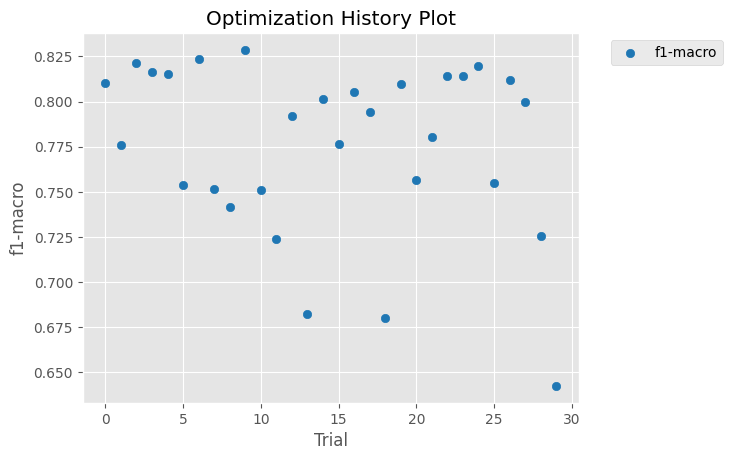

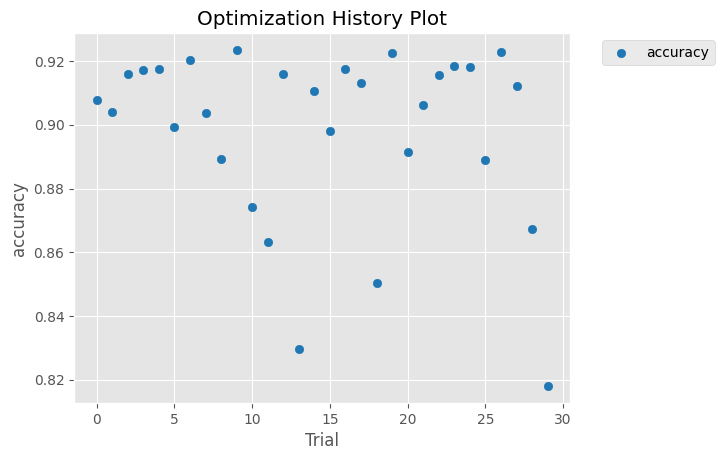

In [70]:
from optuna.visualization.matplotlib import plot_optimization_history


print("Optuna optimization history plots for MLP:")
plot_optimization_history(mlp_study, target= lambda t: t.values[0], target_name='f1-macro')
plot_optimization_history(mlp_study, target= lambda t: t.values[1], target_name='accuracy')
pass


Optuna optimization history plots for SVM:


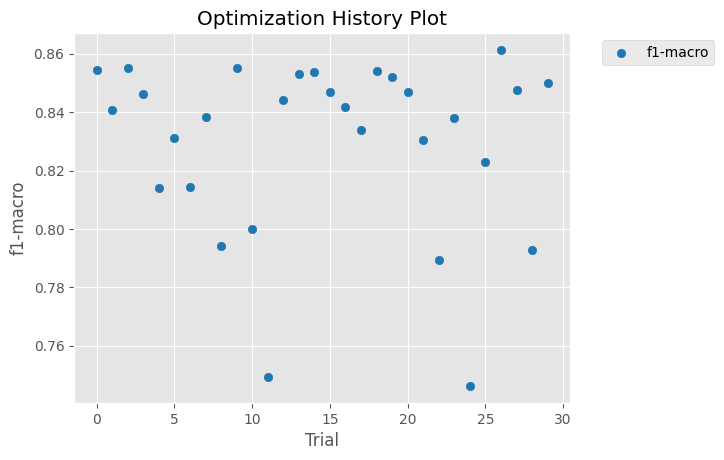

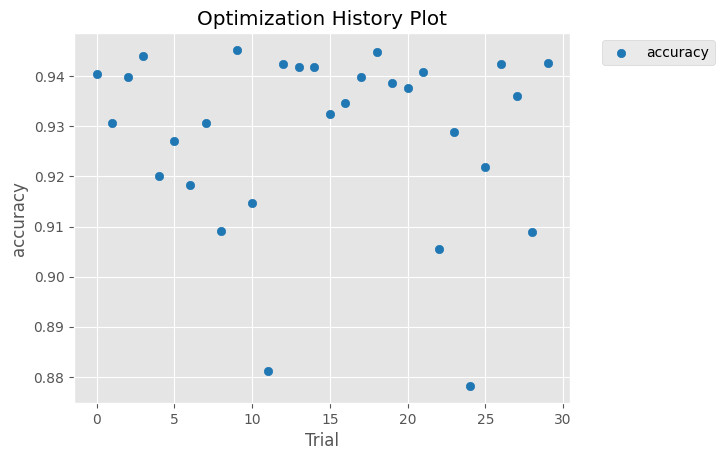

In [71]:
from optuna.visualization.matplotlib import plot_optimization_history


print("Optuna optimization history plots for SVM:")
plot_optimization_history(svc_study, target= lambda t: t.values[0], target_name='f1-macro')
plot_optimization_history(svc_study, target= lambda t: t.values[1], target_name='accuracy')

pass 

In [67]:
from IPython.display import Markdown

merged_metrics = [(k, float(kaggle_fit[k]), float(kaggle_pred[k]), kaggle_accuracy[k], kaggle_f1[k]) for k in sorted(kaggle_accuracy, key=kaggle_accuracy.get, reverse=True)]

df = pd.DataFrame(merged_metrics, columns=['Classifier', 'Fit Time(s)', 'Test Time(s)','Accuracy','F1-macro'])
Markdown(df.to_markdown())

|    | Classifier          |   Fit Time(s) |   Test Time(s) |   Accuracy |   F1-macro |
|---:|:--------------------|--------------:|---------------:|-----------:|-----------:|
|  0 | optuna_svc          |   13.6263     |   13.6263      |  0.942426  | 0.861316   |
|  1 | svm_opt_rbf         |    2.78225    |    2.51837     |  0.93782   | 0.852836   |
|  2 | mlp_opt_adam        |   11.8409     |    0.00510383  |  0.924514  | 0.813236   |
|  3 | optuna_mlp          |   29.6796     |   29.6796      |  0.92349   | 0.828612   |
|  4 | svc_rbf             |    4.46929    |    3.18985     |  0.298106  | 0.0968492  |
|  5 | mlp_adam            |    5.43396    |    0.00485611  |  0.276868  | 0.100331   |
|  6 | svc_poly            |   10.5125     |    1.26711     |  0.237206  | 0.0598049  |
|  7 | dummy_most_frequent |    0.00194502 |    0.000301838 |  0.223644  | 0.0332307  |
|  8 | mlp_sgd             |    1.19249    |    0.00204086  |  0.190123  | 0.0290456  |
|  9 | mlp_lbfgs           |    1.95445    |    0.00511813  |  0.185517  | 0.0462601  |
| 10 | dummy_stratified    |    0.00213099 |    0.00103712  |  0.163767  | 0.0861298  |
| 11 | dummy_uniform       |    0.00280118 |    0.00117397  |  0.093654  | 0.0728173  |
| 12 | dummy_constant      |    0.00193286 |    5.00679e-05 |  0.0437564 | 0.00762219 |

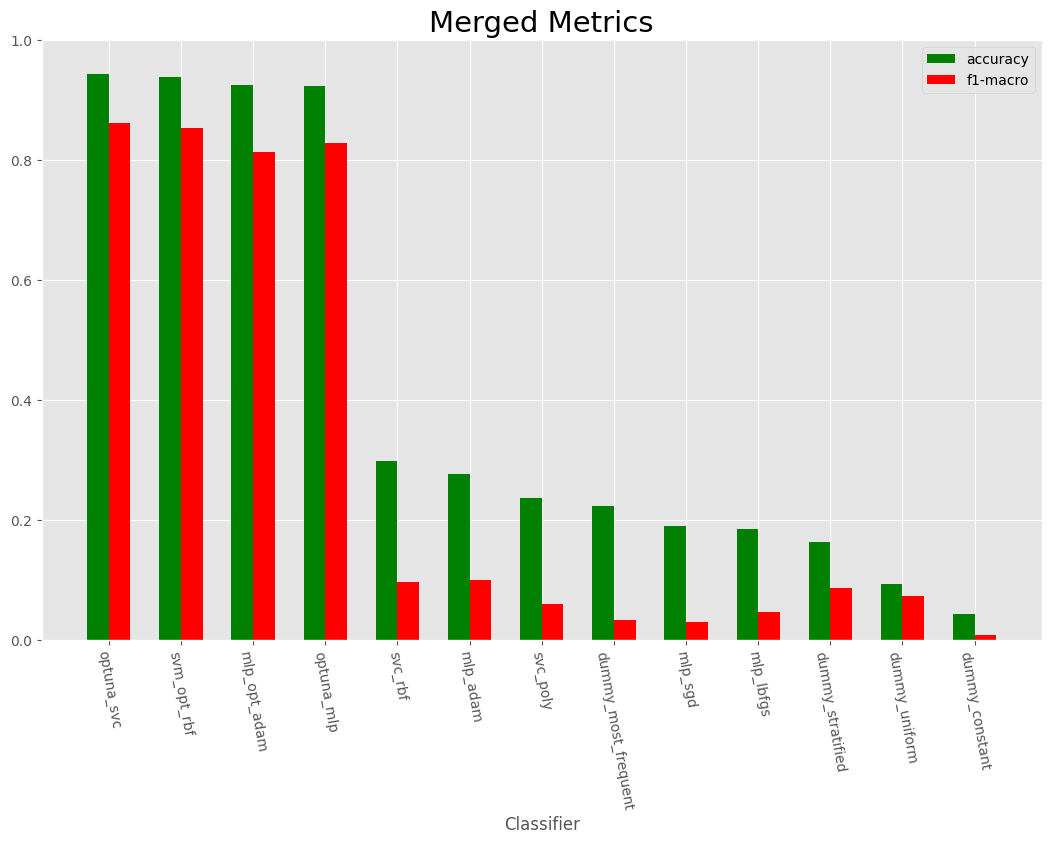

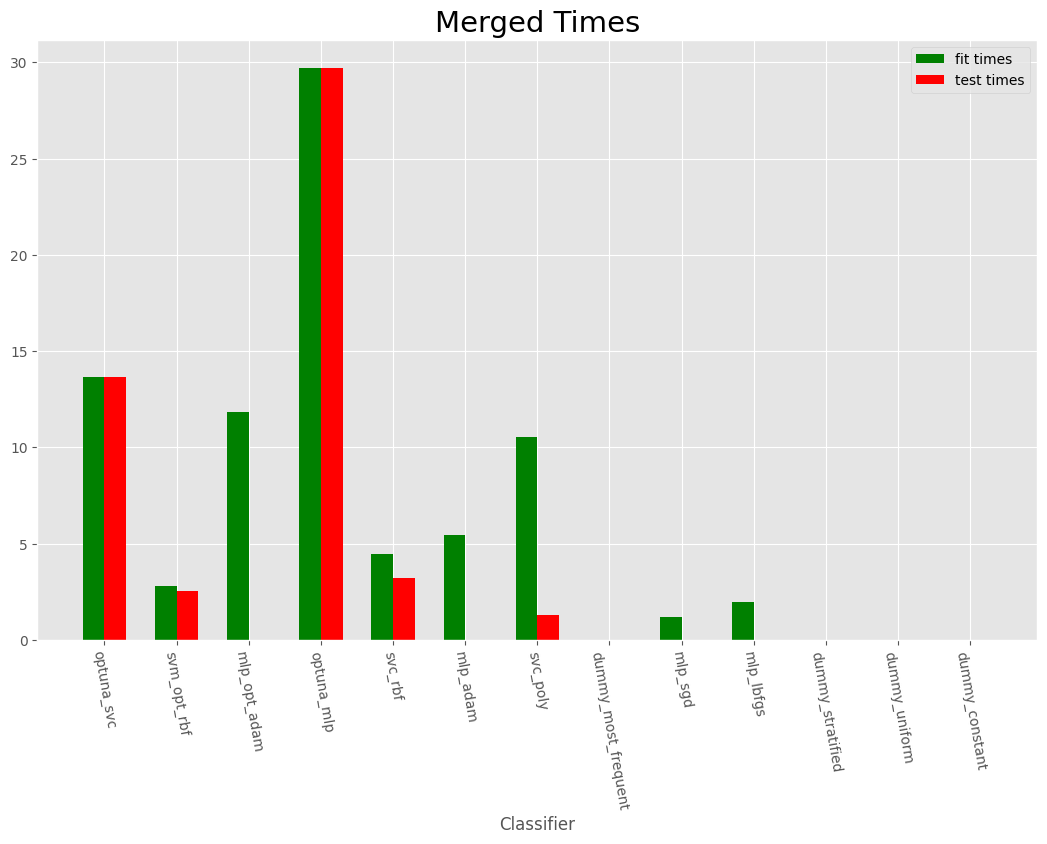

In [68]:
import matplotlib.pyplot as plt

keys, fit_times, test_times, accuracy, f1_macro = zip(*merged_metrics)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, accuracy, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, f1_macro, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['accuracy', 'f1-macro'])
ax.set_title('Merged Metrics',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)

plt.ylim(0, 1)

plt.show()



fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(keys)) - 0.15, fit_times, color = 'g', width = 0.3)
ax.bar(np.arange(len(keys)) + 0.15, test_times, color = 'r', width = 0.3)
plt.xlabel('Classifier')
ax.legend(labels=['fit times', 'test times'])
ax.set_title('Merged Times',fontsize = 21)
plt.xticks(np.arange(len(keys)), keys)
plt.xticks(rotation = 280)


plt.show()

## Συμπεράσματα

Οι χρόνοι που παρουσιάζονται από την χρήση του Optuna αποτελούν συνολικό χρόνο fit & test. 

Παρατηρείται πολύ μεγάλη βελτίωση στην απόδοση των μοντέλων, τόσο με δικές μας βελτιστοποιήσεις, όσο και με την χρήση έτοιμου finetuning

H Optuna βελτίωσε την απόδοση που επιτύχαμε στον SVC, όμως καταφέραμε να δούμε καλύτερες μετρικές στην δική μας υλοποίηση του MLP. Αυτό, βέβαια, μπορεί να οφείλεται σε απειρία μας στη χρήσης του Framework. 

Ξεκάθαρος νικητής για την επιλογή μας αποτελεί το Optuna SVC μοντέλο, αφού συνδυάζει μικρό χρόνο εκπαίδευσης αλλά και την βέλτιστη απόδοση, σχετικά με τα υπόλοιπα.